In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_approx import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor
from torch import autograd
torch.manual_seed(4)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

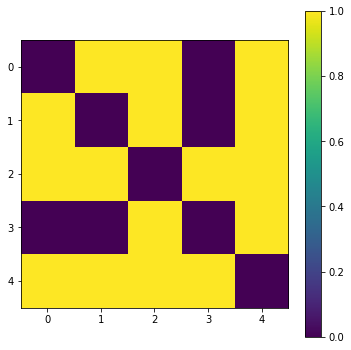

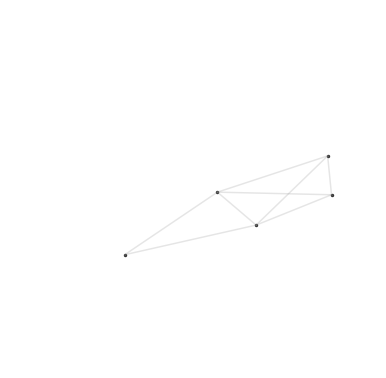

In [5]:
N = 5
R = torch.tensor([5.0]).double()
alpha = .7
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [6]:
r_loc_init = logit(noise_r(r, R, rel_var=0.05)/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = torch.cat((polar2cart(1, noise_phi(theta, 0.02)),  torch.zeros([N,1]).double()), dim=-1)
phi_loc_init.shape

torch.Size([5, 3])

In [7]:
r_loc_init

tensor([ 1.8354,  1.9024, -0.4989,  0.5558, -1.4038], dtype=torch.float64)

In [8]:
Radius(r_loc_init, r_scale_init.exp(), R.expand([N])).mean

tensor([4.3120, 4.3508, 1.8890, 3.1774, 0.9861], dtype=torch.float64)

In [9]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [10]:
T_init

tensor([1.0986, 2.3026])

In [11]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N**2, shuffle=True, num_workers=0)
vi = VI_HRG(N,10, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':None, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [12]:
with autograd.detect_anomaly():
    vi.train(dataloader, lrs=0.1, debug=True, epochs=50)

>>>>>>>>>>>> Start training...
-D_kl(R)    >> tensor(-7.4639, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.8525, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.8176, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-125.9164, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-464.0568, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-26.1030, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(32.3456, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_ri)     >> tensor(204.5961, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_phii)   >> tensor(238.9009, dtype=torch.float64, grad_fn=<MulBackward0>)
ELBO >>>> tensor(-190.9028, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 1 | LR: 0.10 | Total loss: 190.90 | Epoch time 0.14


../src/utils.py:126: UserWarning: cosh_dist has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:126: UserWarning: c has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))
../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


-D_kl(R)    >> tensor(-9.5246, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6422, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.7304, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-171.6600, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-232.0563, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-11.0497, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(6.3521, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_ri)     >> tensor(268.8714, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_phii)   >> tensor(310.2925, dtype=torch.float64, grad_fn=<MulBackward0>)
ELBO >>>> tensor(144.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 2 | LR: 0.10 | Total loss: -144.31 | Epoch time 0.14
-D_kl(R)    >> tensor(-8.0373, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6983, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.66

-D_kl(R)    >> tensor(-6.3563, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6537, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5295, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-84.7364, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-185.5512, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-13.6951, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(10.5479, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_ri)     >> tensor(229.8405, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_phii)   >> tensor(655.1453, dtype=torch.float64, grad_fn=<MulBackward0>)
ELBO >>>> tensor(584.2742, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 13 | LR: 0.10 | Total loss: -584.27 | Epoch time 0.11
-D_kl(R)    >> tensor(-6.5376, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6307, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5

-D_kl(T)    >> tensor(-0.5359, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-59.3837, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-247.8321, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-9.7400, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(8.1815, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_ri)     >> tensor(209.1144, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_phii)   >> tensor(937.1250, dtype=torch.float64, grad_fn=<MulBackward0>)
ELBO >>>> tensor(812.2238, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 23 | LR: 0.10 | Total loss: -812.22 | Epoch time 0.17
-D_kl(R)    >> tensor(-6.6315, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.5868, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5379, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-82.5042, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-262.

-D_kl(R)    >> tensor(-6.5155, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6605, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.5677, dtype=torch.float64, grad_fn=<MulBackward0>)
Prob_edges  >> tensor(-52.5331, dtype=torch.float64, grad_fn=<SumBackward0>)
Alpha_R_ri  >> tensor(-152.3825, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha       >> tensor(-9.6725, dtype=torch.float64, grad_fn=<MulBackward0>)
Alpha_R     >> tensor(5.4615, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_ri)     >> tensor(234.3648, dtype=torch.float64, grad_fn=<MulBackward0>)
P(q_phii)   >> tensor(1347.5063, dtype=torch.float64, grad_fn=<MulBackward0>)
ELBO >>>> tensor(1350.3499, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 34 | LR: 0.10 | Total loss: -1350.35 | Epoch time 0.13
-D_kl(R)    >> tensor(-6.6908, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(alpha)>> tensor(-0.6616, dtype=torch.float64, grad_fn=<MulBackward0>)
-D_kl(T)    >> tensor(-0.

../src/utils.py:124: UserWarning: cosh_dist has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
../src/utils.py:124: UserWarning: c has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
../src/utils.py:124: UserWarning: temp1 has 0 in it!
  warnings.warn(str('%s has 0 in it!' % variable))
sys:1: RuntimeWarning: Traceback of forward call that caused the error:
  File "/home/mo/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mo/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mo/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/m

RuntimeError: Function 'PowBackward1' returned nan values in its 1th output.

In [ ]:
vi.alpha_conc.exp(), vi.alpha_scale.exp()

In [ ]:
vi.rs_loc, vi.rs_scale.exp()

In [ ]:
post_r = Radius(vi.rs_loc, vi.rs_scale.exp(), torch.ones([N]).double()*R)

In [ ]:
Radius(vi.rs_loc, vi.rs_scale.exp(), torch.ones([N])*R).entropy()

In [ ]:
vi.r_i_samples

In [ ]:
vi.R_conc.exp(), vi.R_scale.exp()

In [ ]:
p_hd_ = lambda d,R,T: (1.+((d-R)/(2.*T)).exp()).reciprocal()
phd = lambda d,R,T: 0.5 + 0.5*(-(d-R)/(4*T)).tanh()

In [ ]:
p_hd_(torch.tensor(-np.inf),R,T)

In [ ]:
phd(torch.tensor(5.1),R,T)

In [ ]:
torch.tensor([0.1,10.0]).log()

In [ ]:
x = torch.arange(0.,1.,.01)
plt.plot(x, torch.sigmoid(logit(x)))
plt.show()

In [ ]:
logit(torch.tensor(0.))

In [ ]:
l, n, m = 3, 4, 5
broadcast = torch.ones([l,n])

In [ ]:
torch.rand(m).expand(n,m).t()

In [ ]:
torch.arange(n).expand(m,n)

In [ ]:
torch.tensor(0.).mean()

In [ ]:
arcosh = lambda x: (torch.clamp(x, min=1.) + (torch.clamp(x, min=1.)**2 - 1).sqrt())
arcosh(torch.arange(0.,2., .1))

In [ ]:
torch.clamp(x, min=1.)

In [ ]:
np.log(5)